In [1]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

#for data handaling
from tqdm.auto import tqdm
import numpy as np
import pandas as pd 

#for image processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt

#for calc accuaracy and spliting the data
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
PATH='/kaggle/input/bengaliai-cv19/'
HEIGHT = 137

Using TensorFlow backend.


In [2]:
PATH='/kaggle/input/bengaliai-cv19/'
HEIGHT = 137
WIDTH = 236
SIZE = 64
batch_size = 256
epochs = 64

In [3]:
def crop_resize_image(image_df):
    cropped_resized_img={}
    for i in tqdm(range(len(image_df))):
        image=image_df.iloc[i].values.reshape(HEIGHT,WIDTH)
        _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        x_min=[]
        x_max=[]
        y_min=[]
        y_max=[]
        for cordinate in contours:
            x,y,w,h=cv2.boundingRect(cordinate)
            x_min.append(x)
            x_max.append(x+w)
            y_min.append(y)
            y_max.append(y+h)
        x1=min(x_min)
        x2=max(x_max)
        y1=min(y_min)
        y2=max(y_max)
        cropped_img=image[y1:y2,x1:x2]
        resized_img=cv2.resize(cropped_img,(SIZE,SIZE),interpolation=cv2.INTER_AREA)
        cropped_resized_img[i]=resized_img.reshape(-1)
    return pd.DataFrame(cropped_resized_img).T

In [4]:
inputs= Input(shape=(SIZE,SIZE,1))
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu',input_shape=(SIZE,SIZE,1))(inputs)
#model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Dropout(0.3)(model)
model=BatchNormalization(momentum=0.15)(model)
model=Flatten()(model)
model=Dense(1000,activation='relu')(model)
model=Dropout(0.3)(model)
model=Dense(500,activation='relu')(model)

root=Dense(168,activation='softmax',name='root')(model)
vowel=Dense(11,activation='softmax',name='vowel')(model)
consonant=Dense(7,activation='softmax',name='consonant')(model)

model=Model(inputs=inputs,outputs=[root,vowel,consonant])

In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

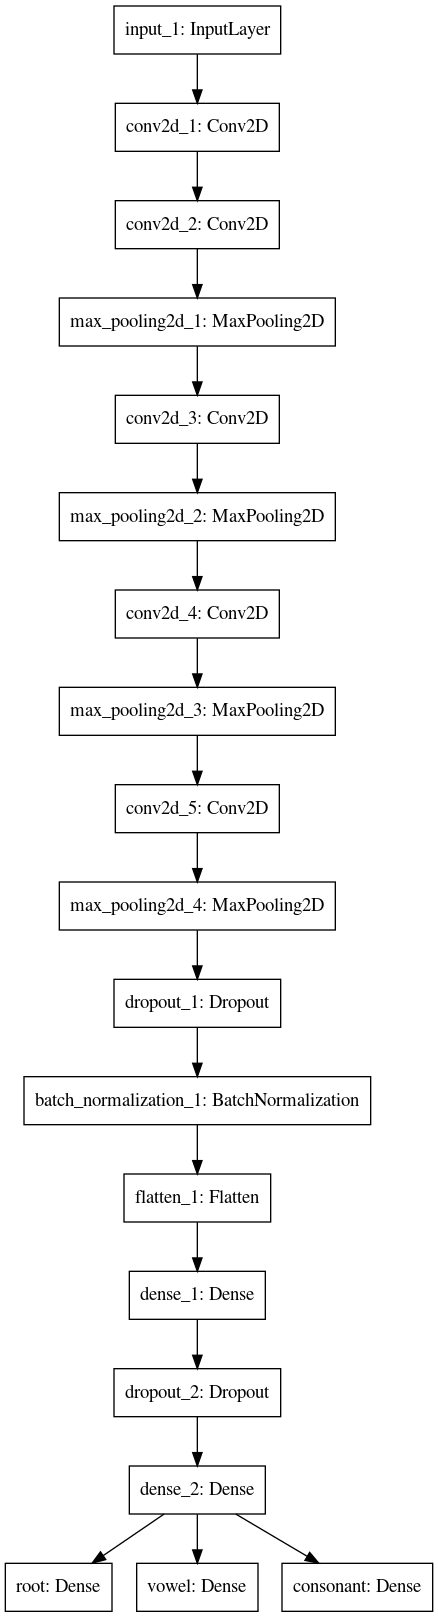

In [8]:
from tensorflow.keras.utils import plot_model
cnn1model = keras.Model(inputs=inputs, outputs=[root,vowel ,consonant])

plot_model(cnn1model, to_file='mode4.png')

In [9]:
lr_root=ReduceLROnPlateau(monitor='root_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)
lr_vowel=ReduceLROnPlateau(monitor='vowel_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)
lr_consonant=ReduceLROnPlateau(monitor='consonant_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=batch_size,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)
            
        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [12]:
train_image=pd.read_parquet(PATH+'train_image_data_3.parquet').drop(['image_id'],axis=1)
train_image_info=pd.read_csv(PATH+'train.csv')

X_train=crop_resize_image(train_image).values.reshape(-1,SIZE,SIZE,1)
Y_train=train_image_info[3*50210:(3+1)*50210]

_, x_test, _, y_test = train_test_split(X_train, Y_train, test_size=0.85, random_state=420)

In [13]:
y_test_root = pd.get_dummies(y_test['grapheme_root']).values
y_test_vowel = pd.get_dummies(y_test['vowel_diacritic']).values
y_test_consonant = pd.get_dummies(y_test['consonant_diacritic']).values
print(y_test_root.shape)

(42679, 168)


In [14]:
del train_image
del X_train
del Y_train

In [15]:
def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [16]:
records={}

for i in range(1,4):
    train_image=pd.read_parquet(PATH+'train_image_data_'+str(i)+'.parquet').drop(['image_id'],axis=1)
    
    y_train=train_image_info[i*50210:(i+1)*50210]
    x_train=crop_resize_image(train_image).values.reshape(-1,SIZE,SIZE,1)
    #plt.imshow(train_image.iloc[100].values.reshape(HEIGHT,WIDTH))
    del train_image

    #plt.imshow(X_train[100])
    #print(Y_train.iloc[100])
    #print('splitting about to start')


    #print('splitting completed')

    data_generator=MultiOutputDataGenerator(
        rotation_range=8,
        width_shift_range=0.08,
        shear_range=0.3,
        height_shift_range=0.08,
        zoom_range=0.08
    )
    data_generator.fit(x_train)
    #print('fitting completed')
    
    y_train_root = pd.get_dummies(y_train['grapheme_root']).values
    y_train_vowel = pd.get_dummies(y_train['vowel_diacritic']).values
    y_train_consonant = pd.get_dummies(y_train['consonant_diacritic']).values
    
    del y_train


    #print('learning about to start')
    result=model.fit_generator(
        data_generator.flow(
            x_train,
            {
                'root':y_train_root,'vowel':y_train_vowel,'consonant':y_train_consonant
            },
            batch_size=batch_size
        ),
        epochs=epochs,
        validation_data=(x_test,[y_test_root,y_test_vowel,y_test_consonant]),
        steps_per_epoch=y_train_root.shape[0]//batch_size,
        callbacks=[lr_root,lr_vowel,lr_consonant]
    )
    del x_train
    del y_train_root
    del y_train_vowel
    del y_train_consonant

    records=appendHist(records,result.history) 


Epoch 1/64
196/196 [==============================] - 39s 197ms/step - loss: 7.4491 - root_loss: 4.6581 - vowel_loss: 1.7070 - consonant_loss: 1.0840 - root_accuracy: 0.0352 - vowel_accuracy: 0.3820 - consonant_accuracy: 0.6429 - val_loss: 5.6193 - val_root_loss: 4.1457 - val_vowel_loss: 0.7801 - val_consonant_loss: 0.6934 - val_root_accuracy: 0.0819 - val_vowel_accuracy: 0.7231 - val_consonant_accuracy: 0.7676
Epoch 2/64


/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `root_acc` which is not available. Available metrics are: val_loss,val_root_loss,val_vowel_loss,val_consonant_loss,val_root_accuracy,val_vowel_accuracy,val_consonant_accuracy,loss,root_loss,vowel_loss,consonant_loss,root_accuracy,vowel_accuracy,consonant_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `vowel_acc` which is not available. Available metrics are: val_loss,val_root_loss,val_vowel_loss,val_consonant_loss,val_root_accuracy,val_vowel_accuracy,val_consonant_accuracy,loss,root_loss,vowel_loss,consonant_loss,root_accuracy,vowel_accuracy,consonant_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: R

196/196 [==============================] - 33s 168ms/step - loss: 4.8792 - root_loss: 3.5208 - vowel_loss: 0.7372 - consonant_loss: 0.6213 - root_accuracy: 0.1662 - vowel_accuracy: 0.7456 - consonant_accuracy: 0.7838 - val_loss: 3.2375 - val_root_loss: 2.4822 - val_vowel_loss: 0.4017 - val_consonant_loss: 0.3536 - val_root_accuracy: 0.3293 - val_vowel_accuracy: 0.8678 - val_consonant_accuracy: 0.8816
Epoch 3/64
196/196 [==============================] - 32s 166ms/step - loss: 3.1626 - root_loss: 2.2334 - vowel_loss: 0.5119 - consonant_loss: 0.4173 - root_accuracy: 0.3940 - vowel_accuracy: 0.8266 - consonant_accuracy: 0.8541 - val_loss: 2.0033 - val_root_loss: 1.4159 - val_vowel_loss: 0.3168 - val_consonant_loss: 0.2704 - val_root_accuracy: 0.5892 - val_vowel_accuracy: 0.8956 - val_consonant_accuracy: 0.9081
Epoch 4/64
196/196 [==============================] - 31s 161ms/step - loss: 2.3495 - root_loss: 1.6012 - vowel_loss: 0.4136 - consonant_loss: 0.3347 - root_accuracy: 0.5416 - vowel

196/196 [==============================] - 31s 158ms/step - loss: 0.7389 - root_loss: 0.4447 - vowel_loss: 0.1622 - consonant_loss: 0.1320 - root_accuracy: 0.8600 - vowel_accuracy: 0.9474 - consonant_accuracy: 0.9550 - val_loss: 0.7036 - val_root_loss: 0.4629 - val_vowel_loss: 0.1299 - val_consonant_loss: 0.1106 - val_root_accuracy: 0.8659 - val_vowel_accuracy: 0.9614 - val_consonant_accuracy: 0.9650
Epoch 22/64
196/196 [==============================] - 32s 162ms/step - loss: 0.7201 - root_loss: 0.4301 - vowel_loss: 0.1575 - consonant_loss: 0.1324 - root_accuracy: 0.8631 - vowel_accuracy: 0.9489 - consonant_accuracy: 0.9540 - val_loss: 0.7032 - val_root_loss: 0.4532 - val_vowel_loss: 0.1264 - val_consonant_loss: 0.1235 - val_root_accuracy: 0.8720 - val_vowel_accuracy: 0.9623 - val_consonant_accuracy: 0.9610
Epoch 23/64
196/196 [==============================] - 31s 158ms/step - loss: 0.6979 - root_loss: 0.4241 - vowel_loss: 0.1511 - consonant_loss: 0.1227 - root_accuracy: 0.8662 - vow

Epoch 41/64
196/196 [==============================] - 32s 161ms/step - loss: 0.4868 - root_loss: 0.2860 - vowel_loss: 0.1108 - consonant_loss: 0.0900 - root_accuracy: 0.9069 - vowel_accuracy: 0.9633 - consonant_accuracy: 0.9700 - val_loss: 0.6799 - val_root_loss: 0.4433 - val_vowel_loss: 0.1223 - val_consonant_loss: 0.1139 - val_root_accuracy: 0.8843 - val_vowel_accuracy: 0.9651 - val_consonant_accuracy: 0.9645
Epoch 42/64
196/196 [==============================] - 31s 159ms/step - loss: 0.4802 - root_loss: 0.2847 - vowel_loss: 0.1099 - consonant_loss: 0.0856 - root_accuracy: 0.9066 - vowel_accuracy: 0.9644 - consonant_accuracy: 0.9708 - val_loss: 0.6619 - val_root_loss: 0.4410 - val_vowel_loss: 0.1165 - val_consonant_loss: 0.1043 - val_root_accuracy: 0.8847 - val_vowel_accuracy: 0.9669 - val_consonant_accuracy: 0.9700
Epoch 43/64
196/196 [==============================] - 32s 162ms/step - loss: 0.4722 - root_loss: 0.2809 - vowel_loss: 0.1081 - consonant_loss: 0.0832 - root_accuracy: 

196/196 [==============================] - 31s 158ms/step - loss: 0.3682 - root_loss: 0.2127 - vowel_loss: 0.0867 - consonant_loss: 0.0687 - root_accuracy: 0.9311 - vowel_accuracy: 0.9711 - consonant_accuracy: 0.9764 - val_loss: 0.6654 - val_root_loss: 0.4449 - val_vowel_loss: 0.1123 - val_consonant_loss: 0.1084 - val_root_accuracy: 0.8896 - val_vowel_accuracy: 0.9701 - val_consonant_accuracy: 0.9700
Epoch 61/64
196/196 [==============================] - 31s 160ms/step - loss: 0.3693 - root_loss: 0.2140 - vowel_loss: 0.0859 - consonant_loss: 0.0694 - root_accuracy: 0.9300 - vowel_accuracy: 0.9727 - consonant_accuracy: 0.9764 - val_loss: 0.6782 - val_root_loss: 0.4422 - val_vowel_loss: 0.1262 - val_consonant_loss: 0.1097 - val_root_accuracy: 0.8899 - val_vowel_accuracy: 0.9667 - val_consonant_accuracy: 0.9692
Epoch 62/64
196/196 [==============================] - 31s 161ms/step - loss: 0.3647 - root_loss: 0.2145 - vowel_loss: 0.0838 - consonant_loss: 0.0665 - root_accuracy: 0.9306 - vow


Epoch 1/64
196/196 [==============================] - 33s 168ms/step - loss: 1.0625 - root_loss: 0.6803 - vowel_loss: 0.2106 - consonant_loss: 0.1717 - root_accuracy: 0.8109 - vowel_accuracy: 0.9359 - consonant_accuracy: 0.9473 - val_loss: 0.5731 - val_root_loss: 0.3696 - val_vowel_loss: 0.1085 - val_consonant_loss: 0.0948 - val_root_accuracy: 0.8921 - val_vowel_accuracy: 0.9686 - val_consonant_accuracy: 0.9707
Epoch 2/64
196/196 [==============================] - 32s 161ms/step - loss: 0.8595 - root_loss: 0.5399 - vowel_loss: 0.1761 - consonant_loss: 0.1435 - root_accuracy: 0.8425 - vowel_accuracy: 0.9449 - consonant_accuracy: 0.9546 - val_loss: 0.5414 - val_root_loss: 0.3509 - val_vowel_loss: 0.0958 - val_consonant_loss: 0.0944 - val_root_accuracy: 0.8980 - val_vowel_accuracy: 0.9733 - val_consonant_accuracy: 0.9705
Epoch 3/64
196/196 [==============================] - 31s 157ms/step - loss: 0.7729 - root_loss: 0.4794 - vowel_loss: 0.1599 - consonant_loss: 0.1335 - root_accuracy: 0.

Epoch 21/64
196/196 [==============================] - 31s 158ms/step - loss: 0.4013 - root_loss: 0.2389 - vowel_loss: 0.0898 - consonant_loss: 0.0726 - root_accuracy: 0.9234 - vowel_accuracy: 0.9704 - consonant_accuracy: 0.9753 - val_loss: 0.5209 - val_root_loss: 0.3373 - val_vowel_loss: 0.0957 - val_consonant_loss: 0.0877 - val_root_accuracy: 0.9095 - val_vowel_accuracy: 0.9744 - val_consonant_accuracy: 0.9746
Epoch 22/64
196/196 [==============================] - 32s 162ms/step - loss: 0.3907 - root_loss: 0.2269 - vowel_loss: 0.0907 - consonant_loss: 0.0731 - root_accuracy: 0.9258 - vowel_accuracy: 0.9707 - consonant_accuracy: 0.9761 - val_loss: 0.5371 - val_root_loss: 0.3463 - val_vowel_loss: 0.0988 - val_consonant_loss: 0.0919 - val_root_accuracy: 0.9063 - val_vowel_accuracy: 0.9736 - val_consonant_accuracy: 0.9732
Epoch 23/64
196/196 [==============================] - 31s 158ms/step - loss: 0.3784 - root_loss: 0.2199 - vowel_loss: 0.0889 - consonant_loss: 0.0696 - root_accuracy: 

Epoch 41/64
196/196 [==============================] - 31s 160ms/step - loss: 0.2905 - root_loss: 0.1658 - vowel_loss: 0.0685 - consonant_loss: 0.0561 - root_accuracy: 0.9447 - vowel_accuracy: 0.9778 - consonant_accuracy: 0.9813 - val_loss: 0.5395 - val_root_loss: 0.3565 - val_vowel_loss: 0.0936 - val_consonant_loss: 0.0891 - val_root_accuracy: 0.9089 - val_vowel_accuracy: 0.9760 - val_consonant_accuracy: 0.9754
Epoch 42/64
196/196 [==============================] - 31s 158ms/step - loss: 0.2903 - root_loss: 0.1687 - vowel_loss: 0.0684 - consonant_loss: 0.0532 - root_accuracy: 0.9442 - vowel_accuracy: 0.9782 - consonant_accuracy: 0.9818 - val_loss: 0.5540 - val_root_loss: 0.3657 - val_vowel_loss: 0.1009 - val_consonant_loss: 0.0872 - val_root_accuracy: 0.9097 - val_vowel_accuracy: 0.9748 - val_consonant_accuracy: 0.9760
Epoch 43/64
196/196 [==============================] - 31s 159ms/step - loss: 0.2828 - root_loss: 0.1609 - vowel_loss: 0.0684 - consonant_loss: 0.0535 - root_accuracy: 

Epoch 61/64
196/196 [==============================] - 31s 156ms/step - loss: 0.2387 - root_loss: 0.1334 - vowel_loss: 0.0587 - consonant_loss: 0.0467 - root_accuracy: 0.9556 - vowel_accuracy: 0.9817 - consonant_accuracy: 0.9839 - val_loss: 0.5674 - val_root_loss: 0.3782 - val_vowel_loss: 0.0977 - val_consonant_loss: 0.0911 - val_root_accuracy: 0.9097 - val_vowel_accuracy: 0.9765 - val_consonant_accuracy: 0.9765
Epoch 62/64
196/196 [==============================] - 32s 162ms/step - loss: 0.2394 - root_loss: 0.1357 - vowel_loss: 0.0596 - consonant_loss: 0.0441 - root_accuracy: 0.9556 - vowel_accuracy: 0.9804 - consonant_accuracy: 0.9848 - val_loss: 0.5734 - val_root_loss: 0.3744 - val_vowel_loss: 0.1014 - val_consonant_loss: 0.0975 - val_root_accuracy: 0.9087 - val_vowel_accuracy: 0.9748 - val_consonant_accuracy: 0.9737
Epoch 63/64
196/196 [==============================] - 31s 159ms/step - loss: 0.2323 - root_loss: 0.1327 - vowel_loss: 0.0579 - consonant_loss: 0.0417 - root_accuracy: 


Epoch 1/64
196/196 [==============================] - 32s 163ms/step - loss: 0.8663 - root_loss: 0.5475 - vowel_loss: 0.1727 - consonant_loss: 0.1462 - root_accuracy: 0.8489 - vowel_accuracy: 0.9493 - consonant_accuracy: 0.9555 - val_loss: 0.3626 - val_root_loss: 0.2298 - val_vowel_loss: 0.0697 - val_consonant_loss: 0.0629 - val_root_accuracy: 0.9306 - val_vowel_accuracy: 0.9798 - val_consonant_accuracy: 0.9810
Epoch 2/64
196/196 [==============================] - 32s 162ms/step - loss: 0.6957 - root_loss: 0.4351 - vowel_loss: 0.1420 - consonant_loss: 0.1185 - root_accuracy: 0.8730 - vowel_accuracy: 0.9562 - consonant_accuracy: 0.9622 - val_loss: 0.3116 - val_root_loss: 0.1891 - val_vowel_loss: 0.0638 - val_consonant_loss: 0.0586 - val_root_accuracy: 0.9437 - val_vowel_accuracy: 0.9824 - val_consonant_accuracy: 0.9828
Epoch 3/64
196/196 [==============================] - 31s 157ms/step - loss: 0.6194 - root_loss: 0.3852 - vowel_loss: 0.1258 - consonant_loss: 0.1084 - root_accuracy: 0.

Epoch 21/64
196/196 [==============================] - 31s 159ms/step - loss: 0.3309 - root_loss: 0.1931 - vowel_loss: 0.0751 - consonant_loss: 0.0627 - root_accuracy: 0.9363 - vowel_accuracy: 0.9767 - consonant_accuracy: 0.9785 - val_loss: 0.0595 - val_root_loss: 0.0319 - val_vowel_loss: 0.0134 - val_consonant_loss: 0.0142 - val_root_accuracy: 0.9913 - val_vowel_accuracy: 0.9963 - val_consonant_accuracy: 0.9964
Epoch 22/64
196/196 [==============================] - 31s 156ms/step - loss: 0.3113 - root_loss: 0.1803 - vowel_loss: 0.0732 - consonant_loss: 0.0578 - root_accuracy: 0.9404 - vowel_accuracy: 0.9781 - consonant_accuracy: 0.9805 - val_loss: 0.0530 - val_root_loss: 0.0275 - val_vowel_loss: 0.0128 - val_consonant_loss: 0.0126 - val_root_accuracy: 0.9924 - val_vowel_accuracy: 0.9967 - val_consonant_accuracy: 0.9965
Epoch 23/64
196/196 [==============================] - 32s 162ms/step - loss: 0.3031 - root_loss: 0.1730 - vowel_loss: 0.0729 - consonant_loss: 0.0571 - root_accuracy: 

Epoch 41/64
196/196 [==============================] - 31s 157ms/step - loss: 0.2333 - root_loss: 0.1324 - vowel_loss: 0.0572 - consonant_loss: 0.0437 - root_accuracy: 0.9561 - vowel_accuracy: 0.9815 - consonant_accuracy: 0.9851 - val_loss: 0.0299 - val_root_loss: 0.0136 - val_vowel_loss: 0.0102 - val_consonant_loss: 0.0061 - val_root_accuracy: 0.9966 - val_vowel_accuracy: 0.9975 - val_consonant_accuracy: 0.9985
Epoch 42/64
196/196 [==============================] - 31s 157ms/step - loss: 0.2337 - root_loss: 0.1329 - vowel_loss: 0.0572 - consonant_loss: 0.0436 - root_accuracy: 0.9562 - vowel_accuracy: 0.9821 - consonant_accuracy: 0.9863 - val_loss: 0.0236 - val_root_loss: 0.0111 - val_vowel_loss: 0.0066 - val_consonant_loss: 0.0058 - val_root_accuracy: 0.9977 - val_vowel_accuracy: 0.9985 - val_consonant_accuracy: 0.9989
Epoch 43/64
196/196 [==============================] - 31s 160ms/step - loss: 0.2342 - root_loss: 0.1324 - vowel_loss: 0.0568 - consonant_loss: 0.0450 - root_accuracy: 

Epoch 61/64
196/196 [==============================] - 31s 157ms/step - loss: 0.1903 - root_loss: 0.1054 - vowel_loss: 0.0500 - consonant_loss: 0.0348 - root_accuracy: 0.9658 - vowel_accuracy: 0.9841 - consonant_accuracy: 0.9887 - val_loss: 0.0164 - val_root_loss: 0.0074 - val_vowel_loss: 0.0037 - val_consonant_loss: 0.0052 - val_root_accuracy: 0.9984 - val_vowel_accuracy: 0.9994 - val_consonant_accuracy: 0.9989
Epoch 62/64
196/196 [==============================] - 32s 162ms/step - loss: 0.1981 - root_loss: 0.1110 - vowel_loss: 0.0500 - consonant_loss: 0.0371 - root_accuracy: 0.9633 - vowel_accuracy: 0.9847 - consonant_accuracy: 0.9877 - val_loss: 0.0150 - val_root_loss: 0.0074 - val_vowel_loss: 0.0040 - val_consonant_loss: 0.0036 - val_root_accuracy: 0.9984 - val_vowel_accuracy: 0.9994 - val_consonant_accuracy: 0.9993
Epoch 63/64
196/196 [==============================] - 31s 157ms/step - loss: 0.1922 - root_loss: 0.1074 - vowel_loss: 0.0486 - consonant_loss: 0.0361 - root_accuracy: 

In [17]:
print(records)

{'val_loss': [5.619275175130491, 3.2375362761149873, 2.0032597674003774, 1.5106591622868932, 1.2312181771406263, 1.107457688898906, 1.072237422599847, 0.9463066141357177, 0.9141413807651091, 0.8698746925771325, 0.8358901732388967, 0.8174411464774868, 0.8028724008707682, 0.7687450895512455, 0.7700480312055226, 0.7690978225139633, 0.7414202249643128, 0.7212195101535438, 0.7115664790970402, 0.7209122652815226, 0.7036075511458341, 0.7032420322934099, 0.6962389596196419, 0.6943215837172284, 0.6953125094688135, 0.701925628533691, 0.6853756538404766, 0.6823130156252617, 0.6766626771911551, 0.6848309137592773, 0.6646459657491914, 0.6767104030655408, 0.6556867821842419, 0.6767705329794779, 0.6907279784175694, 0.693225527575577, 0.6624138350869865, 0.6760023891843413, 0.7001248736346225, 0.6902137112937589, 0.67989250253292, 0.6619004834535942, 0.65872792087602, 0.6429190605982875, 0.6869320273273661, 0.6617279785938961, 0.6698219098309417, 0.660900130629492, 0.6546857339735485, 0.65712493440897

In [18]:
def plot_graph(x,s):
    plt.figure(figsize=(10,10))
    plt.plot(x['val_root_'+s])
    plt.plot(x['val_vowel_'+s])
    plt.plot(x['val_consonant_'+s])
    plt.plot(x['root_'+s])
    plt.plot(x['vowel_'+s])
    plt.plot(x['consonant_'+s])
    plt.title('Learning Dataset '+s)
    plt.ylabel(s)
    plt.xlabel('epoch')
    if s=='accuracy':
        plt.legend(['val_root_'+s,'val_vowel_'+s,'val_consonant_'+s,'root_'+s,'vowel_'+s,'consonant_'+s], loc='best')
    elif s=='loss':
        plt.plot(x['val_'+s])
        plt.plot(x[s])
        plt.legend(['val_root_'+s,'val_vowel_'+s,'val_consonant_'+s,'root_'+s,'vowel_'+s,'consonant_'+s,'val_'+s,s], loc='best')
    plt.show()

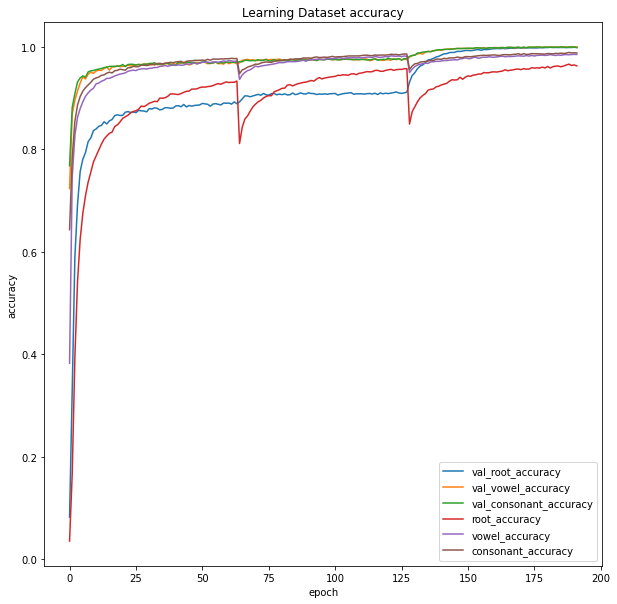

In [19]:
plot_graph(records,'accuracy')

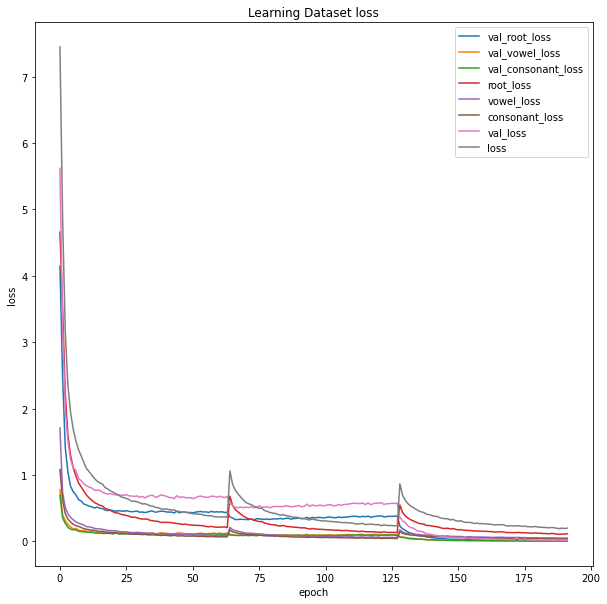

In [20]:
plot_graph(records,'loss')

In [21]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [28]:
row_id=[]
target=[]
for i in range(4):
    test_image=pd.read_parquet(PATH+'test_image_data_'+str(i)+'.parquet')
    test_image.set_index('image_id',inplace=True)
    x_test=crop_resize_image(test_image).values.reshape(-1,SIZE,SIZE,1)
    preds = model.predict(x_test)
    
    for j, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[j], axis=1)
    
    for k,id in enumerate(test_image.index.values):
        row_id+=[id+'_grapheme_root',id+'_vowel_diacritic',id+'_consonant_diacritic']
        target+=[preds_dict['grapheme_root'][k],preds_dict['vowel_diacritic'][k],preds_dict['consonant_diacritic'][k]]

submission = pd.DataFrame({'row_id': row_id, 'target': target})
submission.to_csv('submission.csv', index=False)
print(submission)


                         row_id  target
0          Test_0_grapheme_root       3
1        Test_0_vowel_diacritic       0
2    Test_0_consonant_diacritic       0
3          Test_1_grapheme_root      93
4        Test_1_vowel_diacritic       0
5    Test_1_consonant_diacritic       2
6          Test_2_grapheme_root      19
7        Test_2_vowel_diacritic       0
8    Test_2_consonant_diacritic       0
9          Test_3_grapheme_root     115
10       Test_3_vowel_diacritic       0
11   Test_3_consonant_diacritic       0
12         Test_4_grapheme_root      55
13       Test_4_vowel_diacritic       0
14   Test_4_consonant_diacritic       4
15         Test_5_grapheme_root     115
16       Test_5_vowel_diacritic       0
17   Test_5_consonant_diacritic       2
18         Test_6_grapheme_root     147
19       Test_6_vowel_diacritic       5
20   Test_6_consonant_diacritic       9
21         Test_7_grapheme_root     137
22       Test_7_vowel_diacritic       0
23   Test_7_consonant_diacritic       7

In [29]:
temp = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
preds_dict = {}
preds_dict['grapheme_root']=[]
preds_dict['consonant_diacritic']=[]
preds_dict['vowel_diacritic']=[]

In [31]:
y_test=pd.read_csv(PATH+'test.csv')
for i in range(4):
    test_image=pd.read_parquet(PATH+'test_image_data_'+str(i)+'.parquet')
    test_image.set_index('image_id',inplace=True)
    x_test=crop_resize_image(test_image).values.reshape(-1,SIZE,SIZE,1)
    preds = model.predict(x_test)
    for j, p in enumerate(temp):
        temp[p] = np.argmax(preds[j], axis=1)
    preds_dict['grapheme_root'].extend(temp['grapheme_root'])
    preds_dict['vowel_diacritic'].extend(temp['vowel_diacritic'])
    preds_dict['consonant_diacritic'].extend(temp['consonant_diacritic'])
    #print(len(preds_dict['grapheme_root']))

In [34]:
root_acc=accuracy_score(y_test['grapheme_root'],preds_dict['grapheme_root'])
vowel_acc=accuracy_score(y_test['vowel_diacritic'],preds_dict['vowel_diacritic'])
consonant_acc=accuracy_score(y_test['consonant_diacritic'],preds_dict['consonant_diacritic'])

print('Grapheme Roots accuracy: ',root_acc)
print('Vowel Diacritic accuracy: ',vowel_acc)
print('consonant Diacritic accuracy: ',consonant_acc)

acc=[root_acc,vowel_acc,consonant_acc]
score=np.average(acc,weights=[2,1,1])
print('Score: ',score)

Grapheme Roots accuracy:  0.8537691694881498
Vowel Diacritic accuracy:  0.8875124477195778
consonant Diacritic accuracy:  0.8871091416052579
Score:  0.8705399820752839
